## False Positive Analysis Starts Here!


Train data: ###############################
Number of numeric columns: 8
Original shape: (143468, 28)
Binary shape: (143468, 93)

X_train shape: (143468, 82)

Test data: ###############################
Number of numeric columns: 8
Original shape: (72023, 28)
Binary shape: (72023, 93)

X_test shape: (72023, 82)


[I 2025-01-24 20:53:38,750] A new study created in memory with name: no-name-88e7edf7-99ea-4fde-a239-21c2d9e3230f



Original class distribution:
Counter({1: 131088, 0: 12380})

Resampled class distribution after OSS:
Counter({1: 128177, 0: 12380})


[I 2025-01-24 20:53:40,432] Trial 0 finished with value: 0.9273897308650185 and parameters: {'num_leaves': 21, 'learning_rate': 0.05857242443473979, 'feature_fraction': 0.41097390156397273, 'bagging_fraction': 0.7580051611221477, 'bagging_freq': 3}. Best is trial 0 with value: 0.9273897308650185.
[I 2025-01-24 20:53:41,790] Trial 1 finished with value: 0.9285265495237602 and parameters: {'num_leaves': 31, 'learning_rate': 0.049416094826028614, 'feature_fraction': 0.6755082961135739, 'bagging_fraction': 0.48883392219794186, 'bagging_freq': 7}. Best is trial 1 with value: 0.9285265495237602.
[I 2025-01-24 20:53:44,343] Trial 2 finished with value: 0.9321222067897841 and parameters: {'num_leaves': 118, 'learning_rate': 0.05104334697546208, 'feature_fraction': 0.8566681994808205, 'bagging_fraction': 0.9939398608269009, 'bagging_freq': 3}. Best is trial 2 with value: 0.9321222067897841.
[I 2025-01-24 20:53:45,852] Trial 3 finished with value: 0.925933289496808 and parameters: {'num_leaves':


Best parameters found: {'num_leaves': 114, 'learning_rate': 0.08287704353330784, 'feature_fraction': 0.5517052848915146, 'bagging_fraction': 0.9355165625750206, 'bagging_freq': 3, 'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbose': 0}

Model Evaluation:
-----------------

Accuracy: 0.9402

ROC AUC: 0.9334

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.49      0.58      6186
           1       0.95      0.98      0.97     65837

    accuracy                           0.94     72023
   macro avg       0.84      0.74      0.78     72023
weighted avg       0.93      0.94      0.93     72023


Top 10 Most Important Features:

                                  feature  importance
0                                     age        1496
4                   dividends_from_stocks        1038
5         num_persons_worked_for_employer         696
2                           capital_gains         679
3

C:\Users\Amin\AppData\Local\Temp\ipykernel_20424\3265470457.py:169: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_proba, shade=True)



            fpr       tpr
0      0.000000  0.000000
1      0.000000  0.000015
2      0.000000  0.000137
3      0.000000  0.000167
4      0.000000  0.000273
...         ...       ...
12665  0.983996  0.999970
12666  0.983996  0.999985
12667  0.986906  0.999985
12668  0.986906  1.000000
12669  1.000000  1.000000

[12670 rows x 2 columns]

Model Configuration:

--------------------

Number of training rounds: 100

Model Parameters:

num_leaves: 114

learning_rate: 0.08287704353330784

feature_fraction: 0.5517052848915146

bagging_fraction: 0.9355165625750206

bagging_freq: 3

objective: binary

metric: binary_logloss

boosting_type: gbdt

verbose: 0

Class Distribution in Training Data:

Class counts: 
target
1    131088
0     12380
Name: count, dtype: int64

Class proportions: 
target
1    0.913709
0    0.086291
Name: proportion, dtype: float64

Training History:

----------------

train: OrderedDict({'binary_logloss': 0.13273389010478898})

valid: OrderedDict({'binary_logloss': 0.15645

C:\Users\Amin\AppData\Local\Temp\ipykernel_20424\3265470457.py:246: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('prediction_confidence').agg({


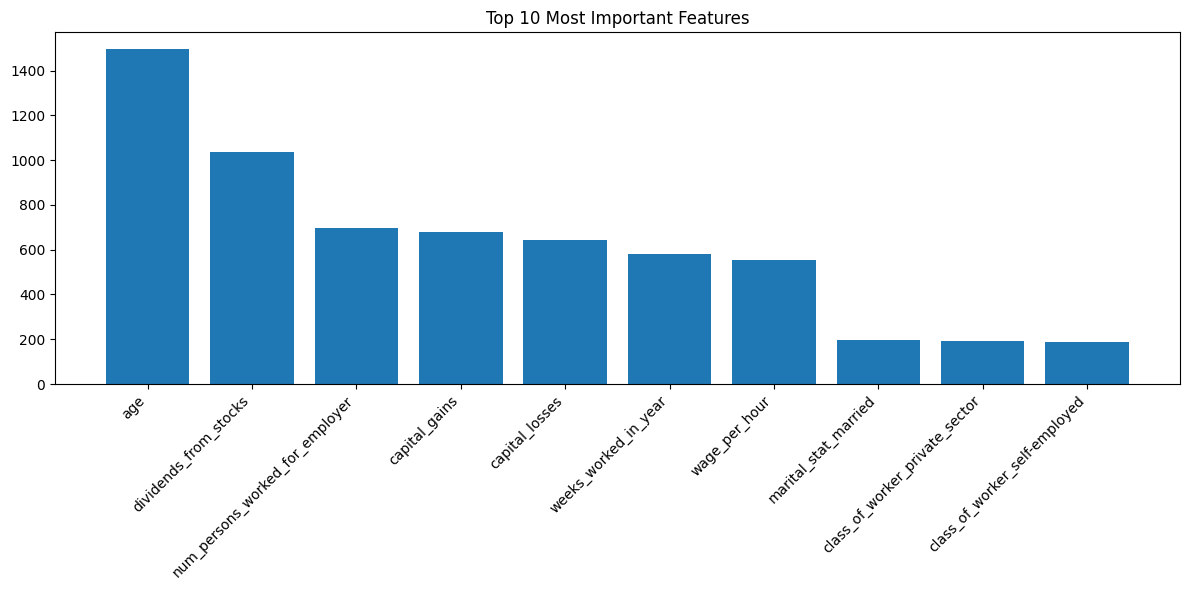

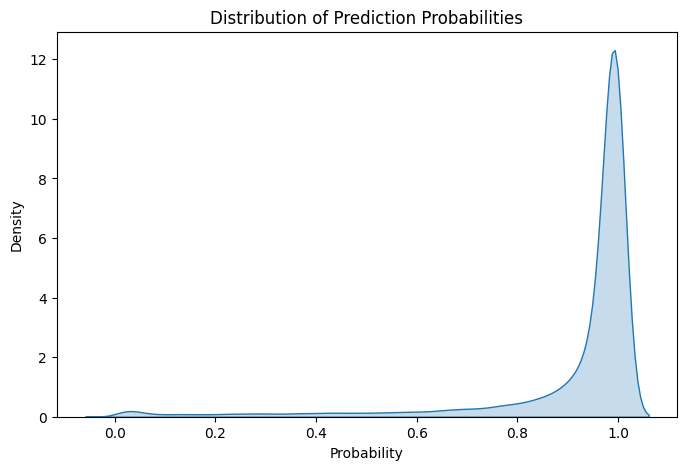

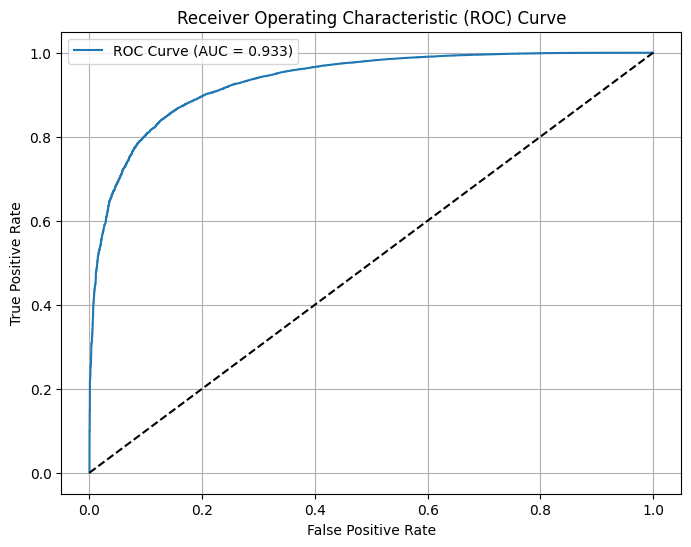

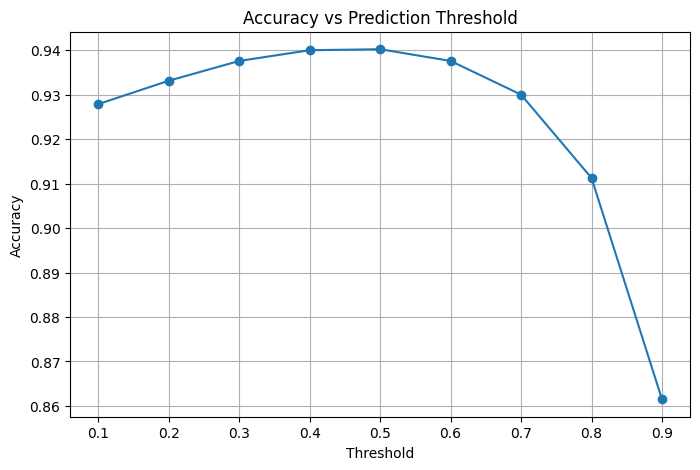

In [6]:
import pandas as pd
import numpy as np
from postprocessing import post_processing
from imblearn.under_sampling import OneSidedSelection
from collections import Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
import optuna
import os
import datetime
import seaborn as sns


train_dir = 'data/processed/census_income_learn.csv'
test_dir = 'data/processed/census_income_test.csv'

# Load the train/test data
# print(f'fitting model {filename} started at {datetime.datetime.now().strftime("%Y-%m-%d %H:%M")}')
print("\nTrain data: ###############################")
X_train, y_train = post_processing(train_dir, get_dummies=True, over_18=True)
X_train = X_train.astype(int)
print(f'\nX_train shape: {X_train.shape}')

print("\nTest data: ###############################")
X_test, y_test = post_processing(test_dir, get_dummies=True, over_18=True)
X_test = X_test.astype(int)
print(f'\nX_test shape: {X_test.shape}')

# Perform OSS
oss = OneSidedSelection(random_state=42)
X_train_oss, y_train_oss = oss.fit_resample(X_train, y_train)

# Print class distribution before and after OSS
print("\nOriginal class distribution:")
print(Counter(y_train))
print("\nResampled class distribution after OSS:")
print(Counter(y_train_oss))

# Create dataset for LightGBM using OSS resampled data
train_data = lgb.Dataset(X_train_oss, y_train_oss)
test_data = lgb.Dataset(X_test, y_test, reference=train_data)

# Define the objective function for Optuna
num_rounds = 100
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'verbose': 0
    }
    
    # Train model with current parameters
    model = lgb.train(
        params,
        train_data,
        num_rounds,
        valid_sets=[test_data],
    )
    
    # Get validation score
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get best parameters
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'verbose': 0
})

print("\nBest parameters found:", best_params)

# Train final model with best parameters
num_rounds = 100
model = lgb.train(
    best_params,
    train_data,
    num_rounds,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid']
)

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba)

# Evaluate model
print("\nModel Evaluation:")
print("-----------------")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\nROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(f'\n{classification_report(y_test, y_pred)}')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(f'\n{feature_importance.head(15)}')

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('\nconfusion_matrix:')
print(cm)
print("--------------------")
# Print confusion matrix values in a tabular format
print("\nConfusion Matrix Values:")
print("--------------------")
print(f"\nTrue Negatives (TN): {cm[0][0]}")
print(f"\nFalse Positives (FP): {cm[0][1]}")
print(f"\nFalse Negatives (FN): {cm[1][0]}")
print(f"\nTrue Positives (TP): {cm[1][1]}")

# Calculate and print percentages
total = cm.sum()
print("\nConfusion Matrix Percentages:")
print("\n-------------------------")
print(f"\nTrue Negatives (TN): {(cm[0][0]/total)*100:.2f}%")
print(f"\nFalse Positives (FP): {(cm[0][1]/total)*100:.2f}%")
print(f"\nFalse Negatives (FN): {(cm[1][0]/total)*100:.2f}%")
print(f"\nTrue Positives (TP): {(cm[1][1]/total)*100:.2f}%")

# Plot and analyze feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
# plt.savefig(f'ML/{filename}feature_importance.png')

# Analyze correlation between top features and predictions
top_features = feature_importance['feature'][:5].tolist()
correlations = pd.DataFrame()
for feature in top_features:
    correlations[feature] = pd.Series({
        'correlation_with_prediction': np.corrcoef(X_test[feature], y_pred)[0,1],
        'mean_value_when_predicted_1': X_test[feature][y_pred == 1].mean(),
        'mean_value_when_predicted_0': X_test[feature][y_pred == 0].mean()
    })

print("\nFeature Correlation Analysis:")
print(f'\n{correlations}')
print("\n--------------------")

# Model performance metrics
print("\nDetailed Model Performance Metrics:")
print(f"\nAccuracy: {np.mean(y_pred == y_test):.4f}")
print(f"\nTrue Positive Rate: {cm[1,1] / (cm[1,0] + cm[1,1]):.4f}")
print(f"\nTrue Negative Rate: {cm[0,0] / (cm[0,0] + cm[0,1]):.4f}")
print(f"\nPositive Predictive Value: {cm[1,1] / (cm[0,1] + cm[1,1]):.4f}")

# Distribution of probabilities
plt.figure(figsize=(8, 5))
sns.kdeplot(y_pred_proba, shade=True)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Probability')
plt.ylabel('Density')
# plt.savefig(f'ML/{filename}_prediction_probabilities.png')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_curve_vals = {'fpr' : fpr, 'tpr' : tpr}
roc_curve_vals = pd.DataFrame(roc_curve_vals)
print(f'\n{roc_curve_vals}')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
# plt.savefig(f'ML/{filename}_roc_curve.png')

# Additional model insights
print("\nModel Configuration:")
print("\n--------------------")
print(f"\nNumber of training rounds: {num_rounds}")
print("\nModel Parameters:")
for key, value in best_params.items():
    print(f"\n{key}: {value}")

# Training data balance analysis
print("\nClass Distribution in Training Data:")
print(f"\nClass counts: \n{y_train.value_counts()}")
print(f"\nClass proportions: \n{y_train.value_counts(normalize=True)}")
# Print model's training history
print("\nTraining History:")
print("\n----------------")
evals_result = {}
for metric, values in model.best_score.items():
    print(f"\n{metric}: {values}")

# Feature importance percentages
total_importance = feature_importance['importance'].sum()
feature_importance['importance_percentage'] = (feature_importance['importance'] / total_importance * 100).round(2)
print("\nFeature Importance Percentages (Top 10):")
print(f'\n{feature_importance[['feature', 'importance_percentage']].head(15)}')

# Calculate prediction threshold analysis
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_metrics = []
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    threshold_metrics.append({'threshold': thresh, 'accuracy': acc})

threshold_df = pd.DataFrame(threshold_metrics)
print("\nPrediction Threshold Analysis:")
print(f'\n{threshold_df}')

# Plot threshold analysis
plt.figure(figsize=(8, 5))
plt.plot(threshold_df['threshold'], threshold_df['accuracy'], marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Prediction Threshold')
plt.grid(True)
# plt.savefig(f'ML/{filename}_threshold_analysis.png')

# Model complexity analysis
print("\nModel Complexity Analysis:")
print(f"\nNumber of trees: {model.num_trees()}")
print(f"\nTotal number of leaves: {model.num_trees() * best_params['num_leaves']}")

# Analyze prediction confidence
confidence_bins = pd.cut(y_pred_proba, bins=15)
confidence_analysis = pd.DataFrame({
    'prediction_confidence': confidence_bins,
    'actual': y_test
}).groupby('prediction_confidence').agg({
    'actual': ['count', 'mean']
})
print("\nPrediction Confidence Analysis:")
print(f'\n{confidence_analysis}')


Once the Model is refitted, you starting the **variable analysis**

In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# False Positive Analysis
print(y_pred.shape)
print(y_test.shape)
print(X_test.shape)

FP = X_test.reset_index()
FP['y_pred'] = y_pred
FP['y_true'] = y_test.reset_index(drop=True)

(72023,)
(72023,)
(72023, 82)


In [8]:
# cross validate
FP[(FP['y_pred'] == 1) & (FP['y_true'] == 0)]['y_pred'].value_counts()

y_pred
1.0    3153
Name: count, dtype: int64

In [10]:
#Getting Only the False Positive
FP1 = FP[(FP['y_pred'] == 1)]
print(f'False Positives shape is {FP1.shape}')

False Positives shape (67838, 85)


Creating some graph functions to be later used

In [60]:
def plot_sorted_distribution(df: pd.DataFrame, x: str, hue: str = 'target', figsize: tuple =(4,3.5), save:bool = False):
    """
    Create a sorted percentage distribution plot
    
    Parameters:
    df (DataFrame): Input dataframe
    x (str): Column name for x-axis
    hue (str): Column name for hue/color separation
    figsize (tuple): Figure size (width, height)
    """
    sns.set_theme(style="ticks")
    plt.figure(figsize=figsize)

    # Calculate proportions and sort categories
    proportions = df.groupby(x)[hue].mean().sort_values(ascending=False)
    sorted_categories = proportions.index.tolist()

    # Create the plot with sorted categories
    sns.histplot(
        data=df, 
        x=df[x].astype('category').cat.reorder_categories(sorted_categories), 
        hue=hue, 
        stat='percent', 
        multiple="fill"
    )
    sns.despine()
    plt.ylabel('Percentage')
    plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')
    plt.xticks(rotation=45, ha='right')
    if save:
        plt.savefig(f'{x}_income')
    pass


def plot_kde_distribution(df: pd.DataFrame, x: str, hue: str = 'target', figsize: tuple = (4,3.5), 
                         fill: bool = True, alpha: float = 0.5, common_norm: bool = False,
                         title: str = None, save: bool = False):
    """
    Create a KDE plot for numerical variables
    
    Parameters:
    df (DataFrame): Input dataframe
    x (str): Column name for x-axis
    hue (str): Column name for hue/color separation
    figsize (tuple): Figure size (width, height)
    fill (bool): Whether to fill the KDE plot
    alpha (float): Transparency of the fill
    common_norm (bool): Whether to normalize the KDE plots together
    title (str): Plot title (optional)
    save (bool): Whether to save the plot
    """
    sns.set_theme(style="ticks")
    plt.figure(figsize=figsize)
    
    # Filter out zero values if present
    
    sns.kdeplot(data=df, x=x, hue=hue, fill=fill, alpha=alpha, common_norm=common_norm)
    plt.title(title)
    sns.despine()
    plt.ylabel('Density')
    plt.legend(labels=['Under 50K', 'Above 50K'])
    
    if save:
        plt.savefig(f'{x}_income_kde')
    pass

def plot_boxplot_distribution(df: pd.DataFrame, x: str, hue: str = 'target', figsize: tuple = (6,4), 
                         fill: bool = True, alpha: float = 0.5, common_norm: bool = False,
                         title: str = None, save: bool = False):
    """
    Create a boxplot for numerical variables
    
    Parameters:
    df (DataFrame): Input dataframe
    x (str): Column name for x-axis
    hue (str): Column name for hue/color separation
    figsize (tuple): Figure size (width, height)
    fill (bool): Whether to fill the boxplot
    alpha (float): Transparency of the fill
    common_norm (bool): Whether to normalize the plots together
    title (str): Plot title (optional)
    save (bool): Whether to save the plot
    """
    sns.set_theme(style="ticks")
    plt.figure(figsize=figsize)
    
    # Create boxplot
    sns.boxplot(data=df, x=hue, y=x)
    sns.despine()
    plt.xlabel('Income Level')
    plt.ylabel(x)
    plt.xticks([0, 1], ['Under 50K', 'Above 50K'])
    
    if title:
        plt.title(title)
    
    if save:
        plt.savefig(f'{x}_income_boxplot')
    pass

def join_binary_columns(df, prefix, sep='_'):
    """
    Combines binary columns back into a single categorical column.
    """
    # Get relevant columns
    cols = [c for c in df.columns if c.startswith(prefix + sep)]
    
    # For each row, get the category name where value is 1
    categories = [c.replace(prefix + sep, '') for c in cols]
    return pd.Series([categories[row.values.argmax()] for _, row in df[cols].iterrows()])

Using **one-hot encoding** to join back the columns that were converted to binary

In [28]:
FP1['race'] = join_binary_columns(FP1, 'race_')
FP1['class_of_worker'] = join_binary_columns(FP1, 'class_of_worker')
FP1['major_industry_code_'] = join_binary_columns(FP1, 'major_industry_code_')
FP1['education'] = join_binary_columns(FP1, 'education')
FP1['enroll_in_edu_inst_last_wk_'] = join_binary_columns(FP1, 'enroll_in_edu_inst_last_wk_')
FP1['full_or_part_time_employment_stat'] = join_binary_columns(FP1, 'full_or_part_time_employment_stat')
FP1['live_in_this_house_1_year_ago_'] = join_binary_columns(FP1, 'live_in_this_house_1_year_ago_')
FP1['reason_for_unemployment'] = join_binary_columns(FP1, 'reason_for_unemployment')
FP1['migration_prev_res_in_sunbelt'] = join_binary_columns(FP1, 'migration_prev_res_in_sunbelt_')
FP1['citizenship'] = join_binary_columns(FP1, 'citizenship')
FP1['own_business_or_self_employed'] = join_binary_columns(FP1, 'own_business_or_self_employed')
FP1['region_of_previous_residence'] = join_binary_columns(FP1, 'region_of_previous_residence_')
FP1['marital_stat_'] = join_binary_columns(FP1, 'marital_stat')

C:\Users\Amin\AppData\Local\Temp\ipykernel_20424\758762154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FP1['race'] = join_binary_columns(FP1, 'race_')
C:\Users\Amin\AppData\Local\Temp\ipykernel_20424\758762154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FP1['class_of_worker'] = join_binary_columns(FP1, 'class_of_worker')
C:\Users\Amin\AppData\Local\Temp\ipykernel_20424\758762154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [25]:
FP1.columns

Index(['index', 'age', 'wage_per_hour', 'capital_gains', 'capital_losses',
       'dividends_from_stocks', 'num_persons_worked_for_employer',
       'weeks_worked_in_year', 'class_of_worker_government',
       'class_of_worker_not_employed', 'class_of_worker_private_sector',
       'class_of_worker_self-employed', 'education_advanced_degree',
       'education_below_high_school', 'education_college_graduate',
       'education_high_school_graduate', 'education_some_college',
       'enroll_in_edu_inst_last_wk__college_or_university',
       'enroll_in_edu_inst_last_wk__high_school', 'marital_stat_divorced',
       'marital_stat_married', 'marital_stat_never_married',
       'marital_stat_separated', 'marital_stat_widowed',
       'major_industry_code__agriculture', 'major_industry_code__armed_forces',
       'major_industry_code__business_and_repair_services',
       'major_industry_code__communications',
       'major_industry_code__construction', 'major_industry_code__education',
   

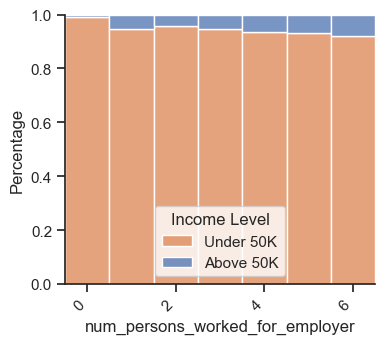

In [61]:
plot_sorted_distribution(
    df= FP1,
    x = 'num_persons_worked_for_employer'
    ,hue= 'y_true')

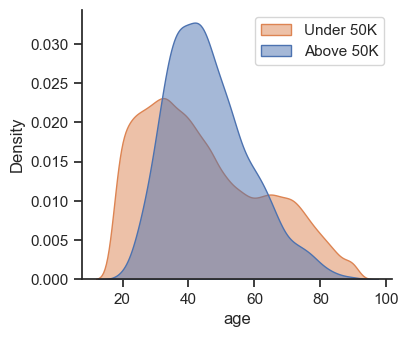

In [62]:
plot_kde_distribution(
    df= FP1,
    x = 'age',
    hue= 'y_true')

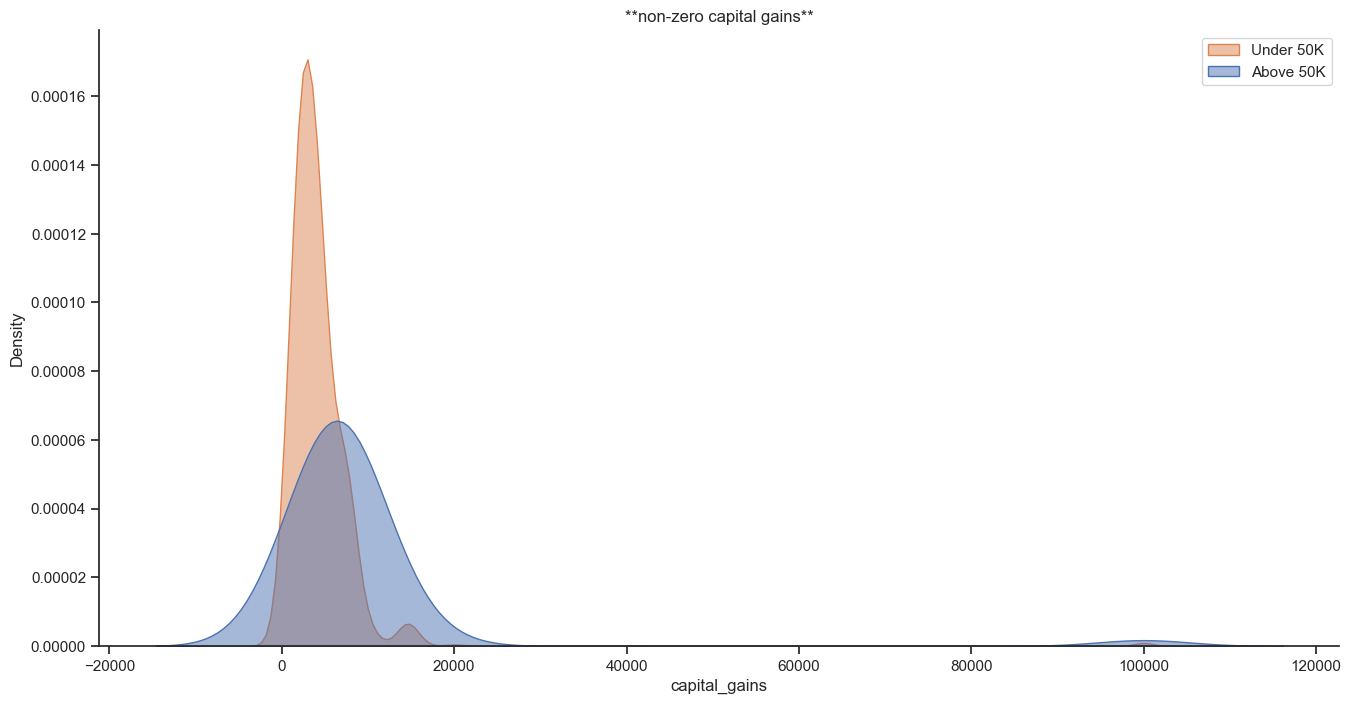

In [80]:
plot_kde_distribution(
    df= FP1[FP1['capital_gains'] > 0],
    x = 'capital_gains',
    title= '**non-zero capital gains**',
    figsize=(16,8),
    hue= 'y_true')

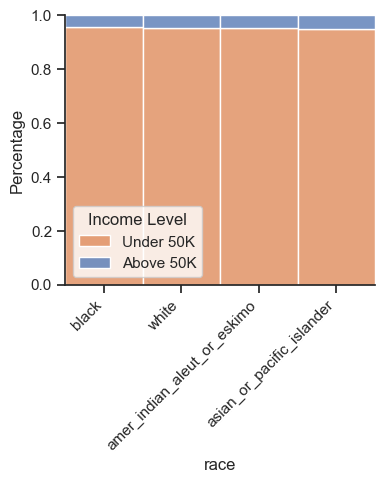

In [64]:
plot_sorted_distribution(
    df= FP1,
    x = 'race',
    hue='y_true'
)

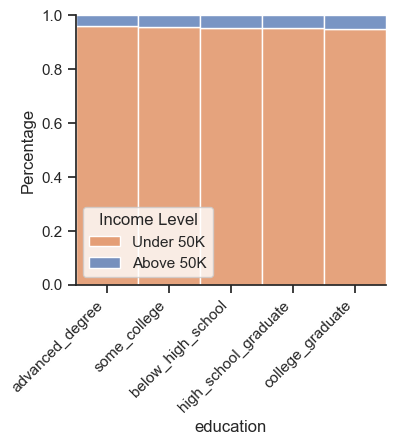

In [65]:
plot_sorted_distribution(
    df= FP1,
    x = 'education',
    hue='y_true'
)

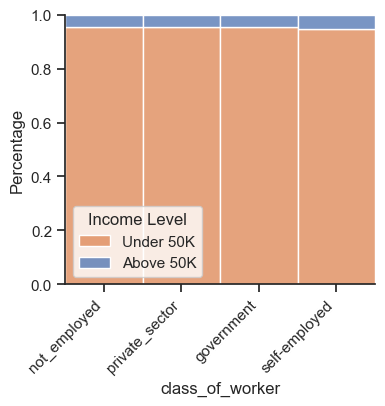

In [66]:
plot_sorted_distribution(
    df= FP1,
    x = 'class_of_worker',
    hue='y_true'
)

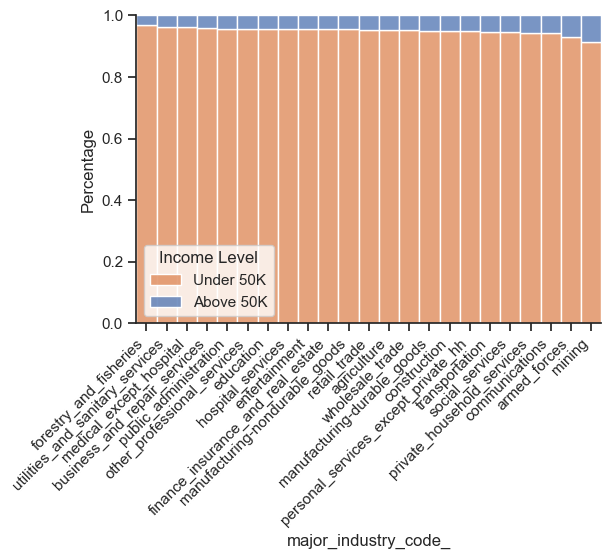

In [67]:

plot_sorted_distribution(
    df= FP1,
    x = 'major_industry_code_',
    hue='y_true',
    figsize=(6,4)
)

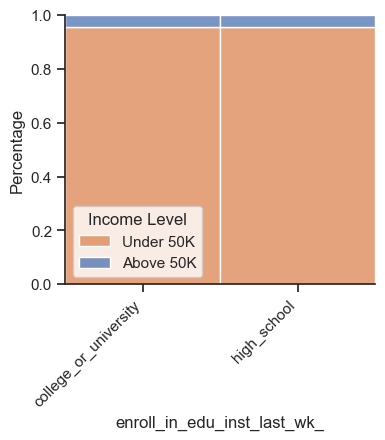

In [68]:

plot_sorted_distribution(
    df= FP1,
    x = 'enroll_in_edu_inst_last_wk_',
    hue='y_true',
    # figsize=(8,6)
)

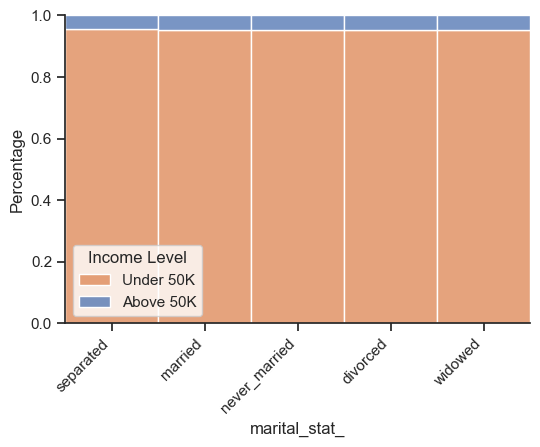

In [40]:

plot_sorted_distribution(
    df= FP1,
    x = 'marital_stat_',
    hue='y_true',
    # figsize=(8,6)
)

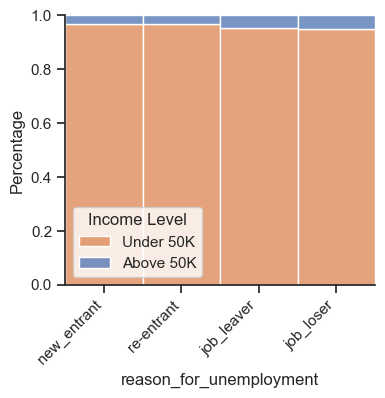

In [69]:
plot_sorted_distribution(
    df= FP1,
    x = 'reason_for_unemployment',
    hue='y_true',
    # figsize=(8,6)
)

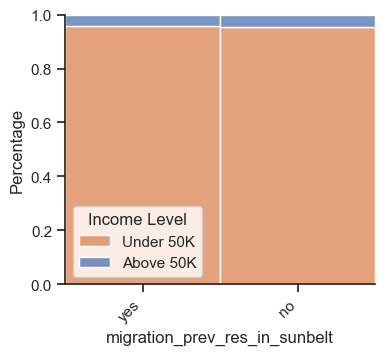

In [70]:

plot_sorted_distribution(
    df= FP1,
    x = 'migration_prev_res_in_sunbelt',
    hue='y_true',
    # figsize=(8,6)
)

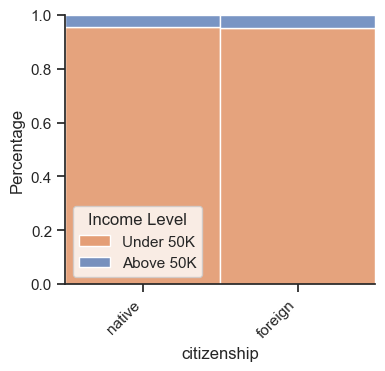

In [71]:

plot_sorted_distribution(
    df= FP1,
    x = 'citizenship',
    hue='y_true',
    # figsize=(8,6)
)

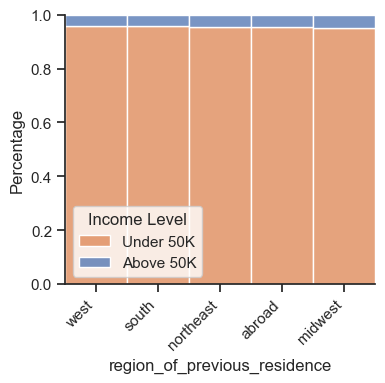

In [72]:
plot_sorted_distribution(
    df= FP1,
    x = 'region_of_previous_residence',
    hue='y_true',
    # figsize=(8,6)
)

In [86]:
# copy the original FP dataframe
FP_edited = FP.copy()
FP_edited['y_pred_rev'] = FP_edited['y_pred']

### Applying model overrides

In [156]:


FP_edited['y_pred_rev'] = FP_edited['y_pred']

condition_1 = (FP_edited['num_persons_worked_for_employer'] == 0)
condition_2 = (FP_edited['capital_gains'] >= 20000)
condition_3 = (FP_edited['age'] < 20)
condition_4 = (FP_edited['age'] > 80)

# FP_edited.loc[condition_1, 'y_pred_rev'] = 1.0
FP_edited.loc[condition_2, 'y_pred_rev'] = 0.0
FP_edited.loc[condition_3, 'y_pred_rev'] = 1.0
# FP_edited.loc[condition_4, 'y_pred_rev'] = 1.0

y_pred_rev = FP_edited['y_pred_rev'].to_list()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_rev)
print('\nconfusion_matrix:')
print(cm)
print("--------------------")
# Print confusion matrix values in a tabular format
print("\nConfusion Matrix Values:")
print("--------------------")
print(f"\nTrue Negatives (TN): {cm[0][0]}")
print(f"\nFalse Positives (FP): {cm[0][1]}")
print(f"\nFalse Negatives (FN): {cm[1][0]}")
print(f"\nTrue Positives (TP): {cm[1][1]}")


# True Negatives (TN): 3033
# False Positives (FP): 3153



confusion_matrix:
[[ 3036  3150]
 [ 1162 64675]]
--------------------

Confusion Matrix Values:
--------------------

True Negatives (TN): 3036

False Positives (FP): 3150

False Negatives (FN): 1162

True Positives (TP): 64675
